In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from scipy.signal import lfilter
from math import cos

from numba import jit

import PyQt5
from Classes import CrankNicolson, Hamiltonian, EMField,WaveFunction
from Functions import Math, GroundState

from IPython.display import clear_output
%matplotlib notebook


<h3> Definición de los parámetros

In [14]:
Nx = 1000 #Número de puntos en el mallado espacial
Nt = 5000 #Número de puntos en el mallado temporal
x,h = np.linspace(-100,100,Nx,retstep=True) 
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
t,dt = np.linspace(0,120,Nt,retstep=True) #Mallado temporal equiespaciado

H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

WF = WaveFunction.WF(a,(x,h),(t,dt),H)
psi = WF.psi


In [15]:
mask

array([0.01150122, 0.56563827, 0.61682868, ..., 0.61682868, 0.56563827,
       0.01150122])

<h3> Absorbing boundary condition

In [16]:
def Mask(x,xb,gamma):
    mask = np.ones(len(x),dtype='float')
    for i in range(len(x)):
        if x[i]<(x[0]+xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
        if x[i]>(x[-1]-xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
    return mask

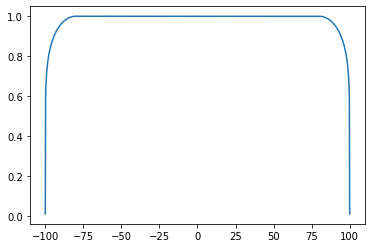

In [17]:
fig = plt.figure();
ax = fig.add_subplot(111); #linear axis

mask = np.nan_to_num(Mask(x,20,1.0))
ax.plot(WF.x,mask)
WF.mask =mask

<h3> Representación de la de la densidad de probabiliad de la
onda de partida 

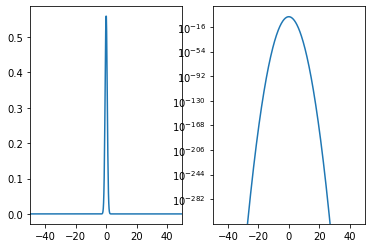

In [18]:
P = WF.P() #Densidad de probabilidad

fig = plt.figure();
axli = fig.add_subplot(121); #linear axis
axlo = fig.add_subplot(122); #logarithmic axis

axli.set_xlim(-50,50)
axlo.set_xlim(-50,50)

axli.plot(WF.x,P);
axlo.plot(WF.x,P);
axlo.set_yscale('log')
plt.show()

<h3> Evolución de la función de onda en ausencia de potencial y campo eléctrico

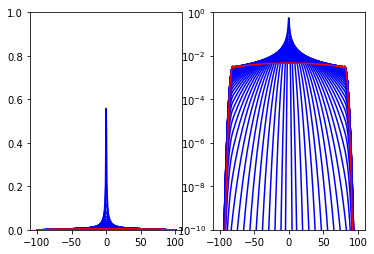

CPU times: user 6min 46s, sys: 3min 32s, total: 10min 19s
Wall time: 2min 43s


In [19]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
WF.psi = WF.WaveFunction()

for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    WF.psi = Prop.Propagate(WF.psi) #Propaga de psi0 a psi1 un dt
    WF.psi= WF.psi*WF.mask
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,WF.P(),'b');
        axlo.plot(x,WF.P(),'b');
    #psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<h3>Cálculo del estado fundamental del Hamiltoniano Coulombiano empleando propagación en tiempo imaginario

In [20]:
%%time 

def f(ep):
    return ep+0.5

delta = 1E-5

epdelta = 1E-5
sa = 1.90
sb = 2.10

eps = 1.

psi = WF.WaveFunction()

while (eps > epdelta): #Secant method
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sa)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epa = GroundState.GroundState(H,Prop,psi,x,delta)[1]

    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sb)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epb = GroundState.GroundState(H,Prop,psi,x,delta)[1]
                                    
    sc = sb-(f(epb))*(sb-sa)/(f(epb)-f(epa))
    
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epc = GroundState.GroundState(H,Prop,psi,x,delta)[1]
    
    eps = abs(abs(epc)-0.5)
    sa = sb
    sb = sc
                                    
print("epc: "+str(epc))
print("sc: " +str(sc))
print("eps: " + str(eps))

epc: (-0.49999998975533283+0j)
sc: (2.0369083358430484+0j)
eps: 1.024466717014505e-08
CPU times: user 5min 41s, sys: 2min 56s, total: 8min 37s
Wall time: 2min 14s


Energy: (-0.5010703141668347+0j)
Softening Parameter: (2.0369083358430484+0j)
Error: 0.21406283336693477
CPU times: user 1min 1s, sys: 31.7 s, total: 1min 33s
Wall time: 25.8 s


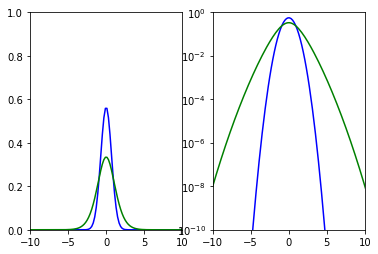

In [21]:
%%time

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)

psi = WF.WaveFunction()
psiG,ep = GroundState.GroundState(H,Prop,psi,x,1E-6)
WF.psi = psiG
WF.H = H
axli.plot(x,np.conjugate(psi)*psi,'b')
axli.plot(x,WF.P(),'g')
axlo.plot(x,np.conjugate(psi)*psi,'b')
axlo.plot(x,WF.P(),'g')
axlo.set_yscale('log')

print("Energy: "+str(WF.Energy()))
print("Softening Parameter: " +str(H.soft))
print("Error: " + str(abs(abs(WF.Energy())-0.5)/0.5*100))

In [8]:
#print("Número de iteraciones: " + str(count))
#print("Energía del estado fundamental" + str(ep1))

<h3>Evolución temporal del estado fundamental

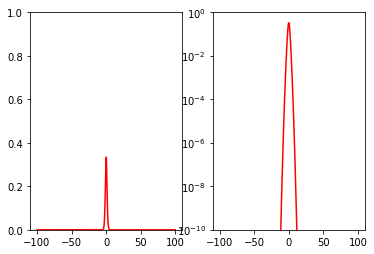

In [9]:
fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)

WF.psi = psiG

axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

In [10]:
dt

0.012001200120012

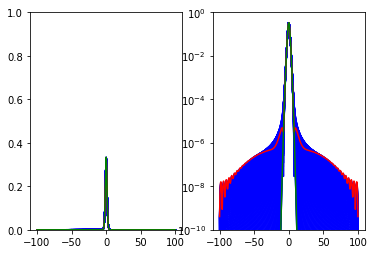

Energía tras evolución: (-0.5010703141796924-1.3169404563442876e-12j)
CPU times: user 13min 39s, sys: 7min 8s, total: 20min 48s
Wall time: 5min 36s


In [11]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
#psi0 = psiG


for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    WF.psi = Prop.Propagate(WF.psi) #Propaga de psi0 a psi1 un dt
    #norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    #psi1 = psi1/np.sqrt(norm) #Normalizamos la función
    #CÓDIGO PARA GUARDAR CAPTURAS DE LAS GRÁFICAS
    #ax.title.set_text("Time: " + str(t[0][i]))
    #ax.plot(x,np.conjugate(psi1)*psi1,'b')
    #path = 'images/FPA/'+str(i)+'.png'
    #plt.savefig(path)
    #ax.clear()
    
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,WF.P(),'b');
        axlo.plot(x,WF.P(),'b');
    #psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
axli.plot(x,np.conjugate(psiG)*psiG,'g'); #Representamos el estado inicial (lineal)
axlo.plot(x,np.conjugate(psiG)*psiG,'g'); #Representamos el estado inicial (logarítmico)
axlo.set_yscale('log')

plt.show()
print("Energía tras evolución: "+str(WF.Energy()))

In [13]:
s = sc
ep = Math.EigenEnergy(WF.psi,H,x)
print("ep: "+str(ep))
print("s: " +str(s))

ep: (-0.5010703141796924-1.3169404563442876e-12j)
s: (2.0369083358430484+0j)


Se observa como existe una diferencia de aproxiamadamente de 1E-3 en la energia al evolucionar el estado fundamental.

<h3>Propagación de la función de onda en presencia de un campo eléctrico

<IPython.core.display.Javascript object>


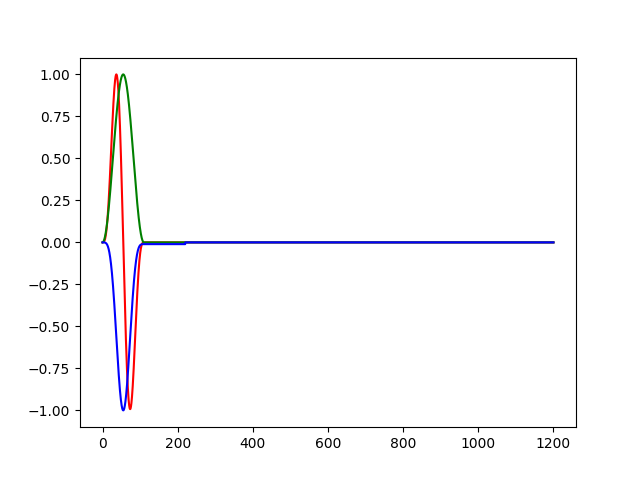

CPU times: user 9.23 s, sys: 64.1 ms, total: 9.3 s
Wall time: 9.15 s


In [99]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
f = np.zeros(Nt)
e = np.zeros(Nt)
a = np.zeros(Nt)
EM = EMField.EMField(0.067,0.057,110)
#e=EM.E(t)
for i in range(len((t))):
    a[i] = EM.A(t[i])
    e[i] = EM.E(t[i])
    f[i] = EM.f(t[i])
    
ax.plot(t,e/np.amax(e),'r')
ax.plot(t,f,'g')
ax.plot(t,a/abs(np.amin(a)),'b')

In [15]:
t,dt = np.linspace(0,240,Nt,retstep=True) #Mallado temporal equiespaciado

Calculando el potencial vector...
potencial vector calculado!
CPU times: user 18min 4s, sys: 9min 58s, total: 28min 2s
Wall time: 7min 32s


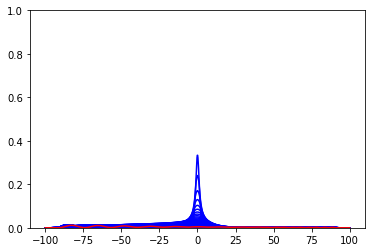

In [22]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
ax.set_ylim(0,1.0)

#a = 10.0 #Paramentro que define el ancho de la función gaussiana
#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
#psi = np.exp(-np.power((x-x0),2)/(2*a**2)) #Funcíón Gaussiana
#psi = psin

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool = True, softening=sc)
Prop = CrankNicolson.Propagator(H,Nx,dt)

WF.psi = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    
    WF.psi = WF.mask*Prop.Propagate(WF.psi)  
    
    if (i%100== 0): #Rpresentamos solamente los multiplos de 100
        ax.plot(x,WF.P(),'b')
        
    #psi0 = psi1 #Preparamos para la siguiente iteración

ax.plot(x,WF.P(),'r'); #Representamos el estado final

In [50]:
 -np.gradient(WF.H.V)

array([ 2.00540407e-05-0.j,  2.00943379e-05-0.j,  2.01751758e-05-0.j,
        2.02565024e-05-0.j,  2.03383217e-05-0.j,  2.04206377e-05-0.j,
        2.05034544e-05-0.j,  2.05867758e-05-0.j,  2.06706061e-05-0.j,
        2.07549495e-05-0.j,  2.08398101e-05-0.j,  2.09251921e-05-0.j,
        2.10110999e-05-0.j,  2.10975378e-05-0.j,  2.11845101e-05-0.j,
        2.12720212e-05-0.j,  2.13600757e-05-0.j,  2.14486780e-05-0.j,
        2.15378326e-05-0.j,  2.16275443e-05-0.j,  2.17178175e-05-0.j,
        2.18086571e-05-0.j,  2.19000678e-05-0.j,  2.19920543e-05-0.j,
        2.20846215e-05-0.j,  2.21777743e-05-0.j,  2.22715177e-05-0.j,
        2.23658566e-05-0.j,  2.24607962e-05-0.j,  2.25563415e-05-0.j,
        2.26524976e-05-0.j,  2.27492699e-05-0.j,  2.28466635e-05-0.j,
        2.29446839e-05-0.j,  2.30433363e-05-0.j,  2.31426263e-05-0.j,
        2.32425593e-05-0.j,  2.33431410e-05-0.j,  2.34443768e-05-0.j,
        2.35462726e-05-0.j,  2.36488341e-05-0.j,  2.37520671e-05-0.j,
        2.38559774e-

<h3>Propagación con el potencial Coulombiano y con campo 
    eléctrico

In [22]:
%%time

#fig = plt.figure();
#ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
#ax.set_ylim(0,1.0)

#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
WF.psi = psiG

#Creamos un array donde se almacenará la densida de probabilidad
PMatrix = np.zeros((Nt,Nx))
aArray = np.zeros(Nt)

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool = True,softening=sc,tmax=110)
WF.H = H
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    PMatrix[i] = np.array(WF.P())
    aArray[i] = WF.aExpected()
    WF.psi = WF.mask*Prop.Propagate(WF.psi)  
    
    #if (i%100== 0): #Rpresentamos solamente los multiplos de 100
    #    ax.plot(x,np.conjugate(psi1)*psi1,'b')
    
    #psi0 = psi1 #Preparamos para la siguiente iteración

#ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

Calculando el potencial vector...
potencial vector calculado!


/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 9min 2s, sys: 4min 45s, total: 13min 47s
Wall time: 3min 39s


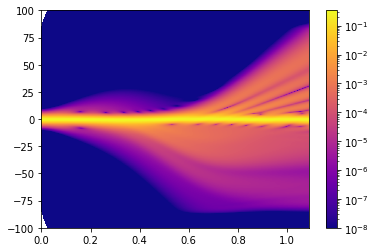

In [23]:
fig = plt.figure();
ax = fig.add_subplot(111);
c = ax.pcolormesh(t/110,x,np.transpose(PMatrix),cmap='plasma',norm=colors.LogNorm(vmin=1E-8,vmax=PMatrix.max()))
fig.colorbar(c, ax=ax)
#ax.plot(t/110,H.A)
#ax.set_yscale('log')
#ax.set_ylim(-10,10)
plt.show()

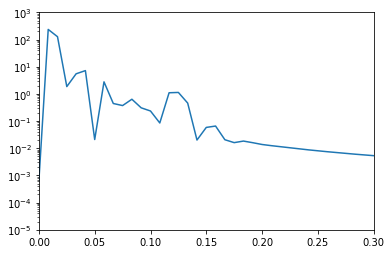

In [24]:
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(0,)

fourier = np.fft.fft(aArray)
Y = np.conjugate(fourier)*fourier
freq = np.fft.fftfreq(len(fourier),dt)
ax.set_xlim(0,0.30)
ax.set_ylim(1e-5,1e3)
ax.plot(freq,Y)
ax.set_yscale('log')
#ax.set_xscale('log')

In [98]:
WF.H.tmax

110